Импорт библиотек

In [1]:
from typing import Optional, Tuple, Literal, Iterable
from abc import abstractmethod, ABC
import copy
import torch
from torch import Tensor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from src.nn import BayesianModule, BayesianLinear, BayesianSequential, BayesianBinaryClassifier


def gini_score(
    y_true,
    y_score,
) -> np.float64:
    return (roc_auc_score(y_true=y_true, y_score=y_score) - 0.5) * 2

def transform_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy(deep=True)
    df["target"] = (df["HeartDisease"] == "Yes").astype("int")
    df = df.drop("HeartDisease", axis=1)
    for column in df.columns:
        value_counts = df[column].value_counts()
        if set(value_counts.index) == {"Yes", "No"}:
            df[column] = (
                (df[column] == "Yes").astype("int")
                - (df[column] == "No").astype("int")
            )
        elif set(value_counts.index) == {"Male", "Female"}:
            df[column] = (
                (df[column] == "Male").astype("int")
                - (df[column] == "Female").astype("int")
            )
        elif column == "AgeCategory":
            to_replace = {}
            for count, value in enumerate(value_counts.sort_index().index):
                to_replace[value] = count
            df[column] = df[column].replace(to_replace).astype("int")
        elif column == "GenHealth":
            to_replace = {
                "Poor": 0,
                "Fair": 1,
                "Good": 2,
                "Very good": 3,
                "Excellent": 4,
            }
            df[column] = df[column].replace(to_replace).astype("int")
        elif column in {"Race", "Diabetic"}:
            for value in value_counts.sort_values(ascending=False).index:
                df[f"{column}_is_{value}"] = (df[column] == value).astype("int")
            df = df.drop(column, axis=1)
    return df

Чтение данных и разбиение на трейн и тест

In [2]:
df = pd.read_csv("data/heart_2020_cleaned.csv")
df = transform_df(df=df)
x = df.drop("target", axis=1)
y = df["target"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

x_mean = x_train.mean(axis=0)
x_std = x_train.std(axis=0)

x_train = (x_train - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

x_train_tensor = torch.from_numpy(x_train.values).float().cuda()
y_train_tensor = torch.from_numpy(y_train.values).view(-1, 1).float().cuda()

x_test_tensor = torch.from_numpy(x_test.values).float().cuda()
y_test_tensor = torch.from_numpy(y_test.values).view(-1, 1).float().cuda()

/tmp/ipykernel_138324/1825769088.py:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = df[column].replace(to_replace).astype("int")
/tmp/ipykernel_138324/1825769088.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = df[column].replace(to_replace).astype("int")


Обучение модели

In [3]:
model = BayesianBinaryClassifier(
    dim_in=x_train.shape[-1],
    dims_hidden=[32]*3,
    f_act="ELU",
    # backbone="Perceptrone",
    backbone="ResNet",
    batch_norm=False,
    batch_penalty=True,
    batch_affine=False,
).cuda()

In [4]:
model.init(x=x_train_tensor, num_epoch=10, optimizer="SGD", lr=0.000001)
model.init(x=x_train_tensor, num_epoch=10, optimizer="SGD", lr=0.0001)
model.init(x=x_train_tensor, num_epoch=10, optimizer="SGD", lr=0.001)
model.init(x=x_train_tensor, num_epoch=10, optimizer="SGD", lr=0.01)
model.df_metrics

,kl
epoch,
0,1.156166e+06
1,1.019280e+04
2,9.919421e+03
3,9.660462e+03
4,9.435391e+03
5,9.224218e+03
6,9.018066e+03
7,8.829339e+03
8,8.656183e+03


,kl,loss,p_item_average
epoch,,,
0,1.156166e+06,NaN,NaN
1,1.019280e+04,NaN,NaN
2,9.919421e+03,NaN,NaN
3,9.660462e+03,NaN,NaN
4,9.435391e+03,NaN,NaN
...,...,...,...
2035,NaN,0.225417,0.798184
2036,NaN,0.225449,0.798158
2037,NaN,0.225481,0.798132


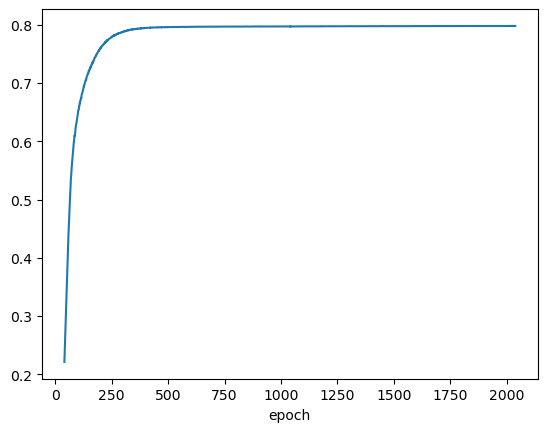

In [5]:
model.fit(
    x=x_train_tensor,
    y=y_train_tensor,
    num_epoch=1_000,
    lr=0.01,
)
model.fit(
    x=x_train_tensor,
    y=y_train_tensor,
    num_epoch=1_000,
    lr=0.005,
)
model.df_metrics["p_item_average"].plot()
model.df_metrics

Предсказание на тесте.
Каждый объект прогоняется через модель 5000

In [6]:
model = model.eval().cpu()
x_test_tensor = x_test_tensor.cpu()
y_test_tensor = y_test_tensor.cpu()

with torch.no_grad():
    y_pred_test_tensor = torch.nn.Sigmoid()(model.eval()(x_test_tensor.expand(500, *x_test_tensor.shape)))
y_pred_test = y_pred_test_tensor.cpu().detach().numpy()

Оценка результата работы на тесте

In [7]:
gini_score(
    y_true=y_test.values,
    y_score=y_pred_test.mean(axis=0).reshape(-1)
)

np.float64(0.6856054068441564)

Сравнение модели со случайным лесом

In [8]:
model_forest = RandomForestClassifier(n_estimators=500)
model_forest.fit(X=x_train, y=y_train)

gini_score(
    y_true=y_test.values,
    y_score=model_forest.predict_proba(X=x_test)[:, 1]
)

np.float64(0.6004072185349976)

Сравнение модели с бустингом

In [9]:
model_boost = GradientBoostingClassifier()
model_boost.fit(X=x_train, y=y_train)

gini_score(
    y_true=y_test.values,
    y_score=model_boost.predict_proba(X=x_test)[:, 1]
)

np.float64(0.6825691756880217)

Сравнение модели с перцептроном

In [10]:
model_mlp = MLPClassifier(hidden_layer_sizes=[30] * 3, activation="relu", max_iter=1000)
model_mlp.fit(X=x_train, y=y_train)

gini_score(
    y_true=y_test.values,
    y_score=model_mlp.predict_proba(X=x_test)[:, 1]
)

np.float64(0.6648784632774456)